# Train a VAE on Cell Painting LINCS Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf


In [4]:
def remove_moa(df):
    pipes = ['opioid receptor agonist|opioid receptor antagonist'
         'glucocorticoid receptor agonist|immunosuppressant',
             'AKT inhibitor|mTOR inhibitor',
             'histamine receptor agonist|histamine receptor antagonist',
            'antiviral|RNA synthesis inhibito']    
    moas =  []
    for pipe in pipes:
        moas.append(pipe)
        moas.append(pipe.split('|')[0])
        moas.append(pipe.split('|')[1])
    return df[~df.moa.isin(moas)]

In [5]:
data_splits = ["train", "test", "valid","complete"]
data_dict = load_data(data_splits)

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

moa_df_train = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=data_dict['train']['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
data_dict['train'] = pd.concat([moa_df_train,data_dict['train']], axis=1)

moa_df_valid = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=data_dict['valid']['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
data_dict['valid'] = pd.concat([moa_df_valid,data_dict['valid']], axis=1)

data_dict['train'] = remove_moa(data_dict['train'])
data_dict['valid'] = remove_moa(data_dict['valid'])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(cp_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [7]:
print(train_features_df.shape)
train_features_df.head(3)

(39095, 685)


,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
0,0.19790,0.69605,0.40400,0.30834,0.19317,0.71895,0.38837,0.38668,0.62494,0.87362,...,0.61045,0.41907,0.64945,0.65199,0.22660,0.32108,0.29776,0.26173,0.34524,0.32151
1,0.18605,0.68873,0.41051,0.31982,0.19885,0.72510,0.39552,0.38362,0.65094,0.89679,...,0.61393,0.38269,0.63814,0.68204,0.23700,0.32808,0.27981,0.26893,0.34938,0.33179
2,0.19083,0.66276,0.38585,0.31437,0.20415,0.71380,0.38701,0.36699,0.60932,0.88492,...,0.60850,0.41850,0.63529,0.65208,0.22852,0.32710,0.29371,0.27159,0.33871,0.31965


In [8]:
print(test_features_df.shape)
test_features_df.head(3)

(5030, 685)


,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
0,0.19050,0.68937,0.39383,0.33072,0.20185,0.72292,0.38085,0.37504,0.61905,0.88361,...,0.60356,0.39345,0.63470,0.63406,0.23588,0.36061,0.30092,0.23638,0.36015,0.32779
1,0.18661,0.67731,0.39621,0.32318,0.20716,0.70964,0.39401,0.37779,0.60275,0.88912,...,0.60936,0.40380,0.64406,0.64859,0.22752,0.29811,0.29430,0.25475,0.34154,0.32013
2,0.18626,0.67036,0.41101,0.31863,0.20182,0.71139,0.40302,0.38979,0.59188,0.86857,...,0.61009,0.40904,0.64250,0.63285,0.23931,0.33179,0.28571,0.24980,0.34516,0.32968


In [9]:
print(complete_features_df.shape)
complete_features_df.head(3)

(50303, 685)


,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
0,0.19575,0.67566,0.40288,0.32633,0.20267,0.71477,0.39122,0.38048,0.61184,0.88375,...,0.60865,0.38869,0.65364,0.65716,0.24912,0.33129,0.28864,0.27106,0.35254,0.32675
1,0.18472,0.66556,0.39721,0.30968,0.20009,0.71345,0.39953,0.37314,0.61074,0.87695,...,0.60682,0.39779,0.64013,0.63120,0.24380,0.30471,0.28554,0.27852,0.35157,0.31637
2,0.18254,0.69650,0.39596,0.33502,0.20420,0.72770,0.39590,0.37023,0.60264,0.88038,...,0.60665,0.39705,0.66616,0.62889,0.25125,0.33549,0.29656,0.25706,0.33868,0.31901


In [10]:

encoder_architecture = [250]
decoder_architecture = [250]



In [11]:

cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=90,
    batch_size=32,
    encoder_batch_norm=True,
    epochs=58,
    learning_rate=0.0001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    verbose=True,
)

cp_vae.compile_vae()

In [12]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/58
1222/1222 [==============================] - 7s 5ms/step - loss: 129.6353 - recon: 54.0967 - kl: 10.2198 - val_loss: 19.6684 - val_recon: 10.9478 - val_kl: 8.7205
Epoch 2/58
1222/1222 [==============================] - 5s 4ms/step - loss: 14.3883 - recon: 7.2157 - kl: 4.8735 - val_loss: 11.9210 - val_recon: 5.4269 - val_kl: 6.4941
Epoch 3/58
1222/1222 [==============================] - 5s 4ms/step - loss: 7.8407 - recon: 4.2692 - kl: 2.6710 - val_loss: 5.9276 - val_recon: 3.4308 - val_kl: 2.4968
Epoch 4/58
1222/1222 [==============================] - 5s 4ms/step - loss: 4.8924 - recon: 2.9849 - kl: 1.4888 - val_loss: 4.0650 - val_recon: 2.4875 - val_kl: 1.5775
Epoch 5/58
1222/1222 [==============================] - 5s 4ms/step - loss: 3.3787 - recon: 2.2199 - kl: 0.8945 - val_loss: 3.1211 - val_recon: 1.9418 - val_kl: 1.1793
Epoch 6/58
1222/1222 [==============================] - 5s 4ms/step - loss: 2.4803 - recon: 1.7621 - kl: 0.5651 - val_loss: 2.5415 - val_recon: 1.5783 -

Epoch 49/58
1222/1222 [==============================] - 5s 4ms/step - loss: 1.0639 - recon: 1.0611 - kl: 2.4687e-04 - val_loss: 1.0115 - val_recon: 1.0108 - val_kl: 6.5761e-04
Epoch 50/58
1222/1222 [==============================] - 5s 4ms/step - loss: 1.0782 - recon: 1.0609 - kl: 2.5722e-04 - val_loss: 1.0075 - val_recon: 1.0069 - val_kl: 5.8917e-04
Epoch 51/58
1222/1222 [==============================] - 5s 4ms/step - loss: 1.0596 - recon: 1.0608 - kl: 1.8697e-04 - val_loss: 1.0094 - val_recon: 1.0082 - val_kl: 0.0012
Epoch 52/58
1222/1222 [==============================] - 5s 4ms/step - loss: 1.0874 - recon: 1.0608 - kl: 1.8402e-04 - val_loss: 1.0095 - val_recon: 1.0087 - val_kl: 8.0616e-04
Epoch 53/58
1222/1222 [==============================] - 5s 4ms/step - loss: 1.0446 - recon: 1.0602 - kl: 2.9380e-04 - val_loss: 1.0126 - val_recon: 1.0110 - val_kl: 0.0017
Epoch 54/58
1222/1222 [==============================] - 5s 4ms/step - loss: 1.0818 - recon: 1.0605 - kl: 2.7776e-04 - val_

In [13]:
cp_vae.vae

In [14]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,recon,kl,val_loss,val_recon,val_kl
0,64.316505,54.096680,10.219783,19.668377,10.947839,8.720538
1,12.089260,7.215728,4.873542,11.920964,5.426912,6.494052
2,6.940200,4.269177,2.671021,5.927580,3.430785,2.496796
3,4.473714,2.984898,1.488818,4.064993,2.487494,1.577499
4,3.114396,2.219883,0.894514,3.121143,1.941799,1.179345
5,2.327183,1.762067,0.565114,2.541533,1.578347,0.963186
6,1.843146,1.486696,0.356449,1.884464,1.343272,0.541192
7,1.542549,1.325839,0.216710,1.707049,1.217910,0.489139
8,1.351371,1.226544,0.124826,1.488801,1.140126,0.348675
9,1.235587,1.166822,0.068765,1.381910,1.097568,0.284342


In [16]:
history_df.to_csv('training_data/level4_training_vanilla_leaveOut.csv')

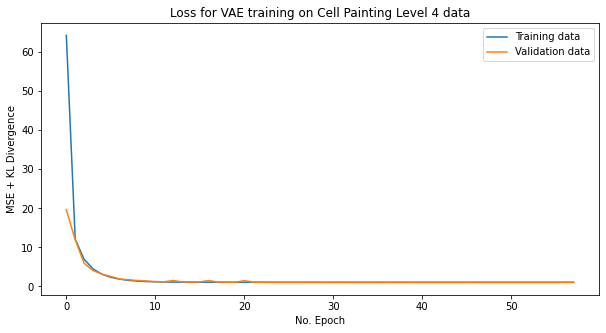

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on Cell Painting Level 4 data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [19]:
cp_vae.vae.evaluate(test_features_df)

158/158 [==============================] - 0s 2ms/step - loss: 0.9888 - recon: 0.9875 - kl: 0.0013


[0.988803505897522, 0.9874852299690247, 0.0013183947885408998]

In [20]:
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

70.47929246693347

<AxesSubplot:>

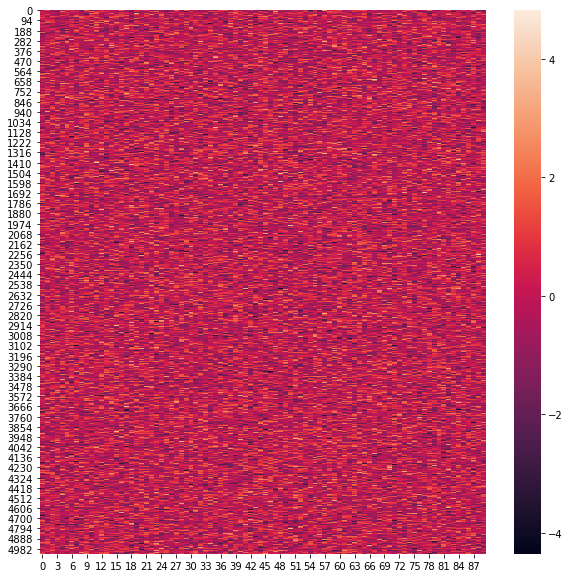

In [21]:
#latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = cp_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [22]:

reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))


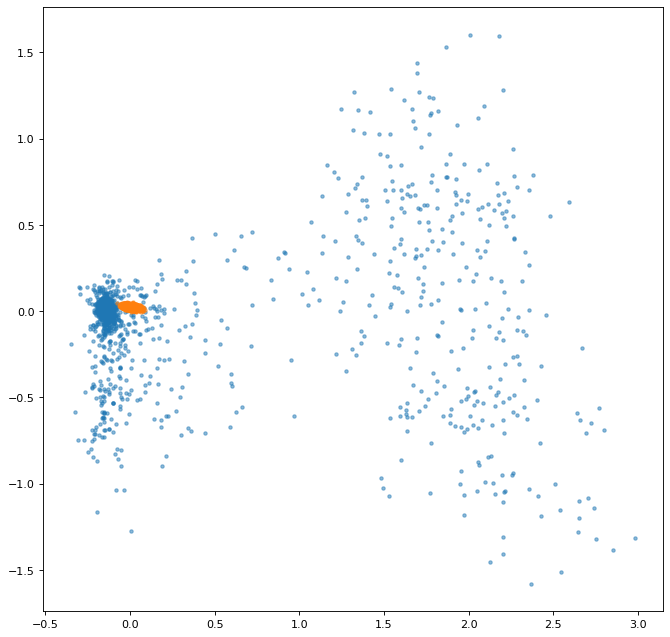

In [23]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)

In [33]:
decoder = cp_vae.decoder_block["decoder"]

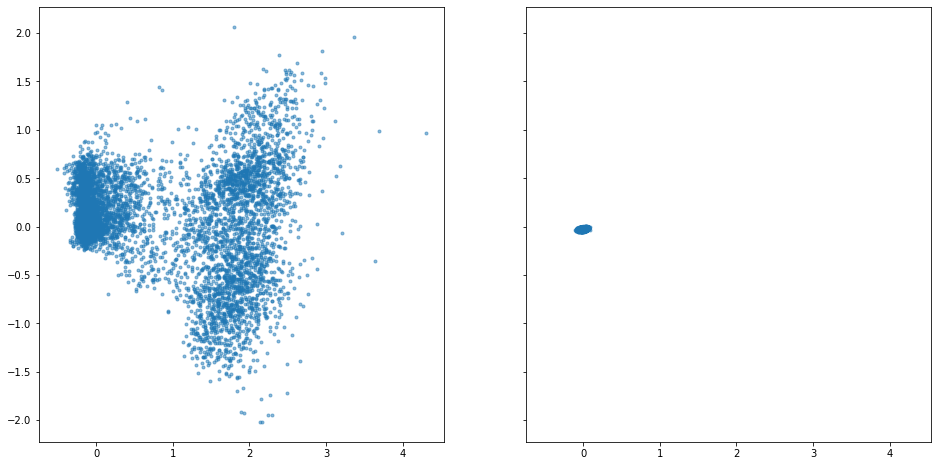

In [34]:
pca_training = PCA(n_components=2).fit(train_features_df)

simulated_df = pd.DataFrame(np.random.normal(size=(40242, 90)), columns=np.arange(0,90))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca_training.transform(reconstruction_of_simulated))
pca_train_latent_df = pd.DataFrame(pca_training.transform(train_features_df))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_train_latent_df[0],pca_train_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [35]:
from scipy.spatial.distance import directed_hausdorff
max(directed_hausdorff(reconstruction_of_simulated, train_features_df)[0],directed_hausdorff(train_features_df,reconstruction_of_simulated)[0])

9.28337373256556

In [36]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent)
latent_df.to_csv("../3.application/level4Latent_vanilla_leaveOut.csv")

In [37]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save("models/level4Decoder_vanilla_leaveOut")

INFO:tensorflow:Assets written to: level4Decoder_vanilla_leaveOut/assets


In [38]:
encoder.save("models/level4Encoder_vanilla_leaveOut")

INFO:tensorflow:Assets written to: level4Encoder_vanilla_leaveOut/assets
